Filtering, imputing and summarizing our data set in various ways and so preparing it for distinct ways of modeling.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import readVCF
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import statsmodels.api as sm
import individual_based_analysis as indba
import patsy
import re

## Import and filter

In [2]:
calls = readVCF.readVCFs()
calls = indba.clean_clinical(calls, remove_ancestry=False)

Welcome, Attila Jones!



Columns with missing values

In [3]:
l = list()
for col in calls.columns:
    missing = len(calls) - len(calls[col].dropna())
    s = pd.Series([missing], index=[col])
    l.append(s)

ss = pd.concat(l).sort_values()
ss.loc[ss != 0]

SiPhyBranchLen         395
SiPhyLOD               395
POSITIVE_TRAIN_SITE    408
NEGATIVE_TRAIN_SITE    408
DS                     410
ExcessHet              410
InbreedingCoeff        410
END                    410
RAW_MQandDP            410
dtype: int64

In [4]:
calls = calls.dropna(axis=1)
repr(list(calls.columns))

"['REF', 'ALT', 'QUAL', 'FILTER/PASS', 'FILTER/HC', 'FILTER/EXT', 'AC', 'AF', 'AN', 'BaseQRankSum', 'DP', 'FS', 'MLEAC', 'MLEAF', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR', 'VQSLOD', 'culprit', 'ChromatinState_DLPFC', 'szdbCNVcount', 'GWASpval', 'chromatinState_DLPFC', 'evolConstrain', 'Sample', 'Ethnicity', 'AntipsychTyp', 'AntipsychAtyp', 'Alcohol', 'Genotyping_Sample_ID', 'Cluster', 'EV.1', 'EV.2', 'EV.3', 'EV.4', 'EV.5']"

The following columns are clearly redundant.  Remove them! 

In [5]:
calls = calls.drop(columns=['ChromatinState_DLPFC', 'Sample', 'Genotyping_Sample_ID', 'Cluster'])

In [6]:
calls.var()

QUAL              284000.959820
AC                    16.962729
AF                     0.006785
AN                     0.000000
BaseQRankSum           4.213420
DP                  1850.319309
FS                     8.992422
MLEAC                 16.264273
MLEAF                  0.006506
MQ                     0.000082
MQRankSum              0.000254
QD                     7.964278
ReadPosRankSum         1.058938
SOR                    0.199890
VQSLOD                14.127486
szdbCNVcount          14.684364
GWASpval              10.692724
evolConstrain          0.035333
AntipsychTyp           0.190977
AntipsychAtyp          0.114640
Alcohol                0.042078
EV.1                   0.000696
EV.2                   0.002535
EV.3                   0.002381
EV.4                   0.000524
EV.5                   0.002459
dtype: float64

`AN` has zero sample variance.  `MQ` and `MQRankSum` have nearly zero sample variance.  Remove them!

In [7]:
calls = calls.drop(columns=['AN', 'MQ', 'MQRankSum'])

## Correlations between factors

First turn factors to dummy variables and then calculate the correlation matrix.  For simplicity we treat `object` type variables as factors and not binary $\{0, 1\}$ valued categorical variables.

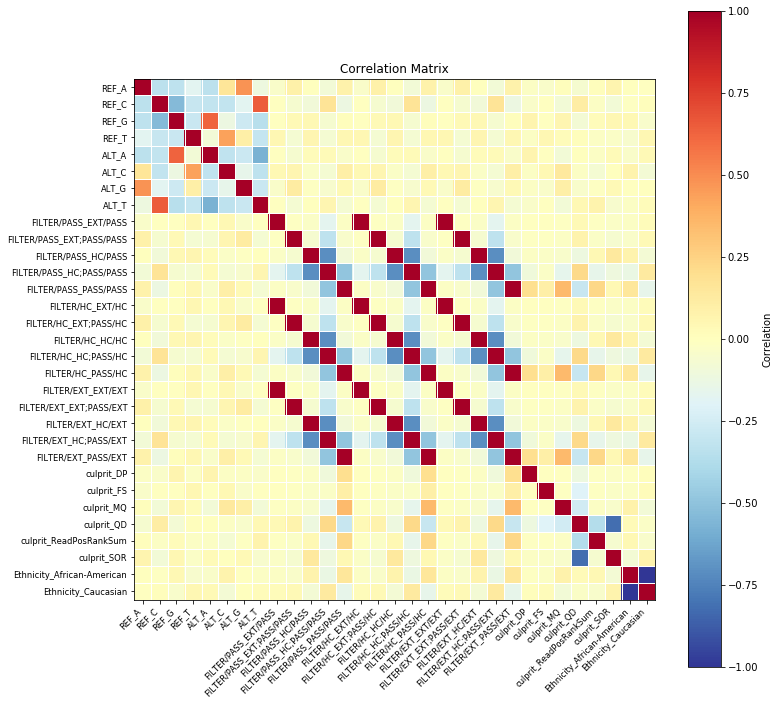

In [8]:
%matplotlib inline
factors = calls.select_dtypes(include='object')
dummies = pd.get_dummies(factors)
fig, ax = plt.subplots(figsize=(11,11))
sm.graphics.plot_corr(dummies.corr(), ax=ax, xnames=dummies.columns, ynames=dummies.columns)
cb = plt.colorbar(ax.get_images()[0])
cb.set_label('Correlation')

Remove redundancies!

In [9]:
redundant_vars = ['FILTER/HC', 'FILTER/EXT']
factors = factors.drop(columns=redundant_vars)
cols2drop = np.array([[y for y in dummies.columns if re.match(x + '_.*', y)] for x in redundant_vars]).flatten()
dummies = dummies.drop(columns=cols2drop)

## Correlations between covariates (numeric var)

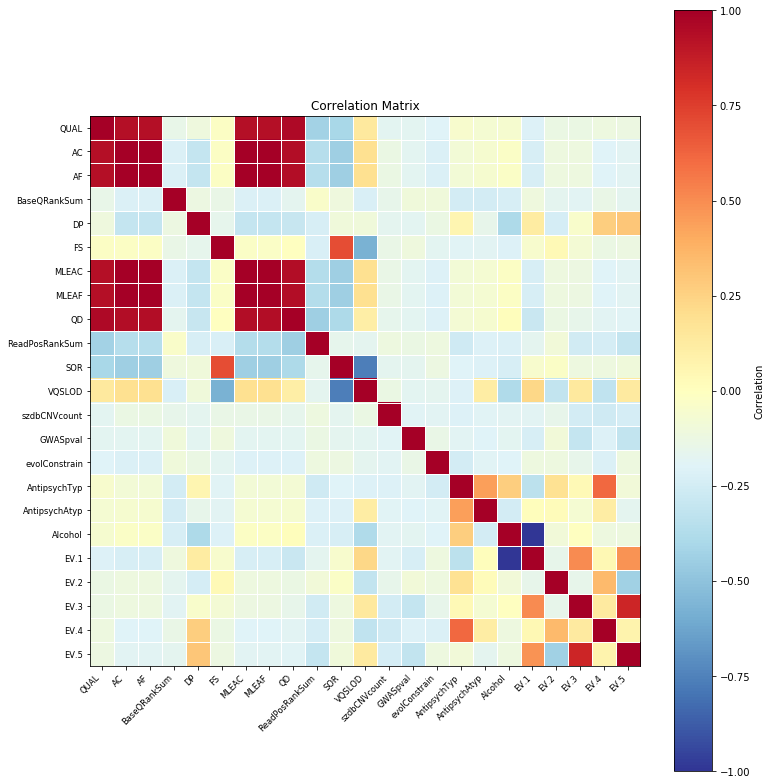

In [10]:
covariates = calls.select_dtypes(exclude=['object', 'category'])
sm.graphics.plot_corr(covariates.corr(), ax=ax, xnames=covariates.columns, ynames=covariates.columns)

In [11]:
redundant_vars = ['QUAL', 'AC', 'MLEAC', 'MLEAF', 'QD']
covariates = covariates.drop(columns=redundant_vars)

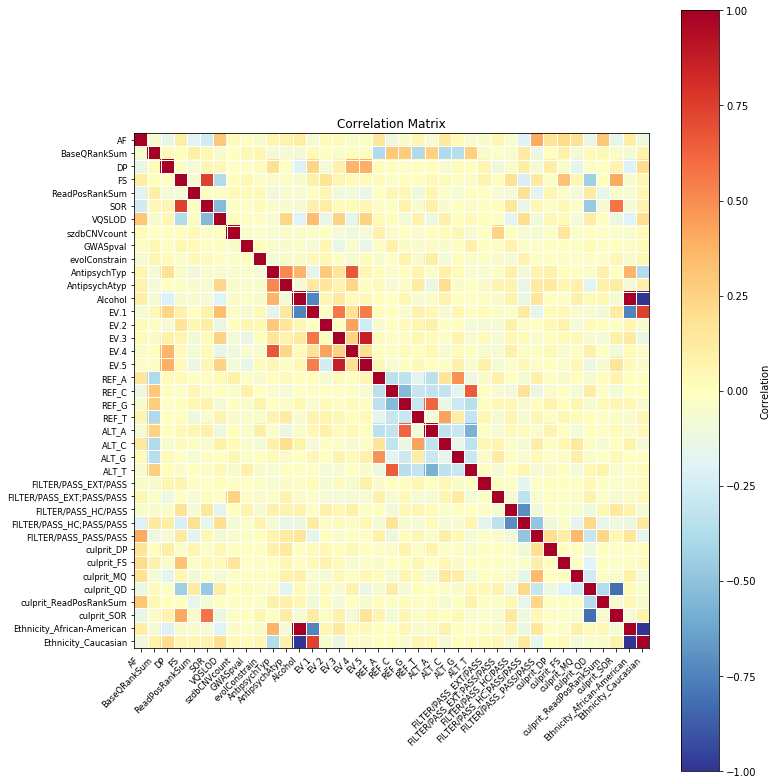

In [12]:
calls_dummy = pd.concat([covariates, dummies], axis=1)
sm.graphics.plot_corr(calls_dummy.corr(), ax=ax, xnames=calls_dummy.columns, ynames=calls_dummy.columns)

It turns out that `Alcohol` correlates perfectly with ethnicity.  This striking result calls into question the fidelity of the clinical data.

In [13]:
m = calls_dummy.corr()
print(m.loc['Ethnicity_African-American', 'Alcohol'], m.loc['Ethnicity_Caucasian', 'Alcohol'])

1.0 -1.0


`Alcohol` is chosen to be excluded as this variable is less reliable than `Ethnicity`.

In [14]:
covariates = covariates.drop(columns='Alcohol')

## Putting things together

In [15]:
calls = pd.concat([covariates, factors], axis=1)
calls.columns

Index(['AF', 'BaseQRankSum', 'DP', 'FS', 'ReadPosRankSum', 'SOR', 'VQSLOD',
       'szdbCNVcount', 'GWASpval', 'evolConstrain', 'AntipsychTyp',
       'AntipsychAtyp', 'EV.1', 'EV.2', 'EV.3', 'EV.4', 'EV.5', 'REF', 'ALT',
       'FILTER/PASS', 'culprit', 'Ethnicity'],
      dtype='object')

### Variant based variables

In [16]:
cmc_clinical_path = '/big/results/bsm/2020-08-05-cmc-clinical/CMC_Human_clinical_metadata.csv'
cmc_clinical = pd.read_csv(cmc_clinical_path, index_col='Individual ID')
ancestry_path='/home/attila/projects/bsm/resources/cmc-ancestry/CMC_MSSM-Penn-Pitt_DNA_GENOTYPE_ANCESTRY_GemTools.tsv'
ancestry = pd.read_csv(ancestry_path, sep='\t', index_col='Individual_ID')
variant_based = set(calls.columns) - set(cmc_clinical.columns) - set(ancestry.columns)
variant_based

{'AF',
 'ALT',
 'BaseQRankSum',
 'DP',
 'FILTER/PASS',
 'FS',
 'GWASpval',
 'REF',
 'ReadPosRankSum',
 'SOR',
 'VQSLOD',
 'culprit',
 'evolConstrain',
 'szdbCNVcount'}

### Individual based variables

In [17]:
individual_based = set(calls.columns) - variant_based
individual_based

{'AntipsychAtyp',
 'AntipsychTyp',
 'EV.1',
 'EV.2',
 'EV.3',
 'EV.4',
 'EV.5',
 'Ethnicity'}

In [18]:
%connect_info

{
  "shell_port": 56329,
  "iopub_port": 56345,
  "stdin_port": 54861,
  "control_port": 34795,
  "hb_port": 32837,
  "ip": "127.0.0.1",
  "key": "448ee8ea-d94f3bf21f297b3471e5d2cf",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-686f21da-b9f9-417e-9beb-9a225e228d55.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
